###  Fixed-Point Algorithms for Inverse Scattering Problems Governed by the Helmholtz Equation with Sommerfeld Radiation Condition

#### Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch

from iwp.algorithms.algorithms import (
    FISTA,
    ForwardBackward,
    GradientDescent,
    NesterovAcceleratedGradientDescent,
    StronglyConvexNesterovAcceleratedGradientDescent,
)
from iwp.algorithms.plot import plot_all_algorithms_convergence, plot_objective_functions_by_algorithm
from iwp.algorithms.metrics import mae, mse
from iwp.data.load_experiment_data import load_experiment_data
from iwp.data.export import save_complex_vector
from iwp.utils.config import load_yaml_into_namespace
from iwp.utils.logger import setup_logger
from iwp.utils.utils import copy_file, make_dirs, set_seed

#### Define config, functions and constants

In [2]:
from types import SimpleNamespace
args = SimpleNamespace(
    config = os.path.join(os.getcwd(), "src/iwp/config.yaml"),
)
args = load_yaml_into_namespace(args.config, args)

logger = setup_logger(
    name="iwp",
    log_file=None,
    level=args.log_level,
    log_to_console=args.log_to_console,
)

# Setup device and seed
if args.device == "cuda" and not torch.cuda.is_available():
    logger.warning("CUDA is not available. Falling back to CPU.")
    args.device = "cpu"
if args.device not in ["cpu", "cuda"]:
    raise ValueError("Device must be either 'cpu' or 'cuda'.")
logger.info(f"Using device: {args.device}")
set_seed(args.seed)

# Load data
A, B_list, C, d_list, m = load_experiment_data(args.data_path)
A_star = A.conj().T
C_star = C.conj().T

I = len(B_list)
J, L = C.shape
P = B_list[0].shape[1]
logger.info(f"Dimensions: I={I}, J={J}, L={L}, P={P}")

row_blocks = []
for i in range(I):
    blocks = [sp.csr_matrix((J, L))] * I + [sp.csr_matrix((J, P))]
    blocks[i] = sp.csr_matrix(C)
    row_blocks.append(sp.hstack(blocks, format="csr"))
D = sp.vstack(
    row_blocks, format="csr"
)  # shape: (I*J, I*L + P) if A is (L,L), B_i is (L,P)
D_star = D.conj().T

d = np.concatenate(d_list, axis=0)  # shape: (I*J,)

row_blocks = []
for i in range(I):
    blocks = [sp.csr_matrix((L, L))] * I + [-B_list[i]]
    blocks[i] = sp.csr_matrix(A)
    row_blocks.append(sp.hstack(blocks, format="csr"))
E = sp.vstack(row_blocks, format="csr")  # shape: (I*L, I*L + P)
E_star = E.conj().T

def get_J_1(d, lambd, mu):
    def J_1(x):
        Dx_minus_d = D @ x - d
        Ex = E @ x
        return (
            0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
            + 0.5 * lambd * np.vdot(Ex, Ex).real
            + 0.5 * mu * np.vdot(x, x).real
        )

    return J_1

def get_dJ_1(d, lambd, mu):
    def dJ_1(x):
        Dx_minus_d = D @ x - d
        Ex = E @ x
        return D.conj().T @ Dx_minus_d + lambd * E_star @ Ex + mu * x

    return dJ_1

def get_closed_form_solution_J_1(d, lambd, mu):
    def closed_form_solution_J_1():
        return sp.linalg.spsolve(
            D.conj().T @ D + lambd * E_star @ E + mu * sp.eye(I * L + P),
            D.conj().T @ d,
        )

    return closed_form_solution_J_1

def get_K_J_1(lambd, mu):
    K_op_J_1 = D.conj().T @ D + lambd * E_star @ E + mu * sp.eye(I * L + P)
    K_eigenvalues_J_1 = np.linalg.eigvals(K_op_J_1.toarray())
    return np.max(np.abs(K_eigenvalues_J_1))

def get_J_2(d, mu, threshold=1e-6):
    def J_2(x):
        Dx_minus_d = D @ x - d
        Ex = E @ x
        if np.linalg.norm(Ex) < threshold:
            return (
                0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
                + 0.5 * mu * np.vdot(x[-P:], x[-P:]).real
            )
        else:
            return np.inf

    return J_2

def get_grad_J_2(d, mu):
    def grad_J_2(x):
        reg = np.zeros_like(x)
        reg[-P:] = mu * x[-P:]
        return D_star @ (D @ x - d) + reg

    return grad_J_2

def get_prox_J_2():
    def prox_J_2(x, gamma):
        w = sp.linalg.spsolve(E @ E_star, E @ x)
        return x - E_star @ w

    return prox_J_2

def get_K_J_2(mu):
    K_op_J_2 = D.conj().T @ D + mu * sp.eye(I * L + P)
    K_eigenvalues_J_2 = np.linalg.eigvals(K_op_J_2.toarray())
    return np.max(np.abs(K_eigenvalues_J_2))

def get_J_3(d_list, mu):
    def J_3(m):
        total = 0.0
        for i in range(len(B_list)):
            CA_inv_Bi_m = C @ sp.linalg.spsolve(A, B_list[i] @ m)
            diff = CA_inv_Bi_m - d_list[i]
            total += 0.5 * np.vdot(diff, diff).real
        return total + 0.5 * mu * np.vdot(m, m).real

    return J_3

def get_dJ_3(d_list, mu):
    def dJ_3(m):
        p_sum = sum(
            B_i.conj().T
            @ sp.linalg.spsolve(
                A_star,
                C_star @ (C @ sp.linalg.spsolve(A, B_i @ m) - d_i),
            )
            for B_i, d_i in zip(B_list, d_list)
        )
        return p_sum + mu * m

    return dJ_3

def get_K_J_3(mu):
    Ainv = sp.linalg.inv(A.tocsc())
    K_op_J_3 = sum(
        B_i.conj().T @ Ainv.conj().T @ C.conj().T @ C @ Ainv @ B_i for B_i in B_list
    ) + mu * sp.eye(P)
    K_eigenvalues_J_3 = np.linalg.eigvals(K_op_J_3.toarray())
    return np.max(np.abs(K_eigenvalues_J_3))

2025-09-16 16:38:07 - iwp - INFO - Using device: cpu
2025-09-16 16:38:07 - iwp - INFO - Set seed for all random number generators to seed 42
2025-09-16 16:38:07 - iwp - INFO - Found 2 B matrices.
2025-09-16 16:38:07 - iwp - INFO - Loaded data.
2025-09-16 16:38:07 - iwp - INFO - Dimensions: I=2, J=50, L=223, P=394


#### Acceleration scheme effect

We first define the constants, and their dependant functions.

In [3]:
lambd = 1e-4
mu_1 = 1e-6
mu_2 = 1e-6
mu_3 = 1e-6

max_iterations = 10000
x_0 = np.zeros(I * L + P, dtype=np.complex128)  # shape: (I*L + P,)

J_1 = get_J_1(d, lambd, mu_1)
dJ_1 = get_dJ_1(d, lambd, mu_1)
closed_form_solution_J_1 = get_closed_form_solution_J_1(d, lambd, mu_1)
K_J_1 = get_K_J_1(lambd, mu_1)
logger.info(f"Lipschitz constant K_J_1: {K_J_1}")

J_2 = get_J_2(d, mu_2)
grad_J_2 = get_grad_J_2(d, mu_2)
prox_J_2 = get_prox_J_2()
K_J_2 = get_K_J_2(mu_2)
logger.info(f"Lipschitz constant K_J_2: {K_J_2}")

J_3 = get_J_3(d_list, mu_3)
dJ_3 = get_dJ_3(d_list, mu_3)
K_J_3 = get_K_J_3(mu_3)
logger.info(f"Lipschitz constant K_J_3: {K_J_3}")

2025-09-16 16:38:08 - iwp - INFO - Lipschitz constant K_J_1: 5.090999419167316
2025-09-16 16:38:08 - iwp - INFO - Lipschitz constant K_J_2: 5.089197871576659
2025-09-16 16:38:09 - iwp - INFO - Lipschitz constant K_J_3: 0.5827462612350582


2025-09-16 16:38:09 - iwp - INFO - Started P-GD for a maximum of 10000 iterations.
2025-09-16 16:38:14 - iwp - INFO - Stopped after 10000 iterations in 5.648 seconds with 174.43 KB memory used.
2025-09-16 16:38:14 - iwp - INFO - Started P-NAGD for a maximum of 10000 iterations.
2025-09-16 16:38:20 - iwp - INFO - Stopped after 10000 iterations in 5.910 seconds with 188.43 KB memory used.
2025-09-16 16:38:21 - iwp - INFO - Started P-SCNAGD for a maximum of 10000 iterations.
2025-09-16 16:38:26 - iwp - INFO - Stopped after 10000 iterations in 5.741 seconds with 232.21 KB memory used.
2025-09-16 16:38:27 - iwp - INFO - Started FB for a maximum of 10000 iterations.
2025-09-16 16:39:44 - iwp - INFO - Stopped after 10000 iterations in 77.389 seconds with 495.44 KB memory used.
2025-09-16 16:39:45 - iwp - INFO - Started FISTA for a maximum of 10000 iterations.
2025-09-16 16:41:02 - iwp - INFO - Stopped after 10000 iterations in 77.156 seconds with 423.67 KB memory used.
2025-09-16 16:41:02 - i

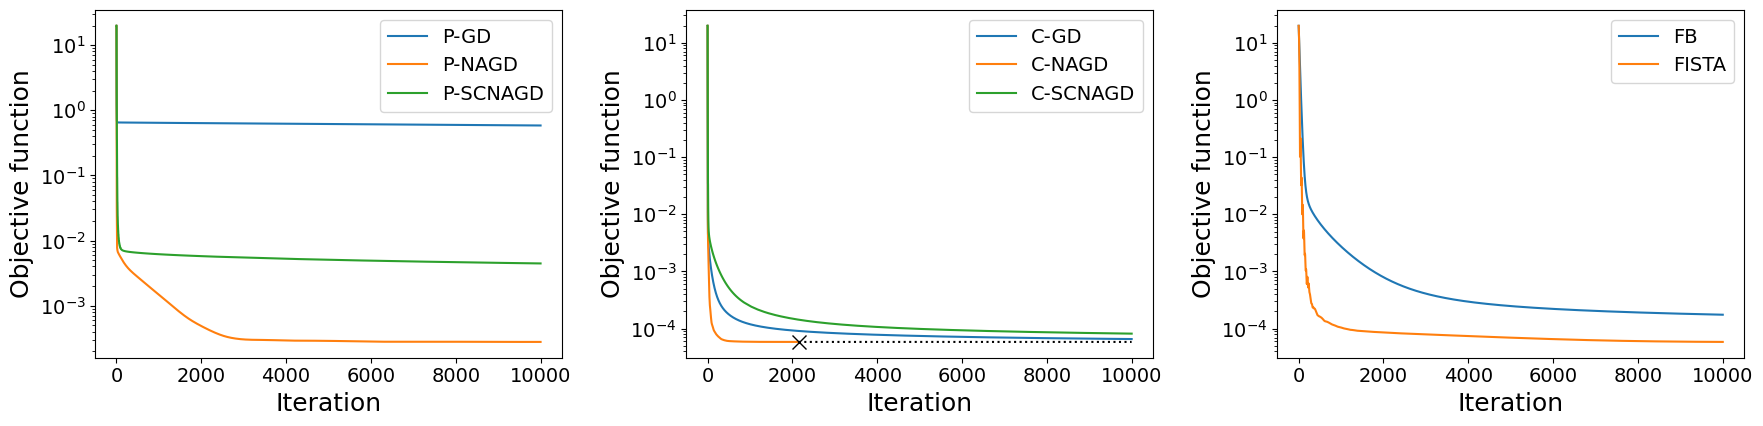

In [4]:
algo_1 = GradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-GD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    gamma=2.0 / K_J_1 - 1e-6,
    logger=logger,
)
x = algo_1.run(x0=x_0, max_iterations=max_iterations)
algo_1.plot_algorithm_convergence(m, None, show=False, save=False)

algo_2 = NesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-NAGD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    logger=logger,
)
algo_2.run(x0=x_0, max_iterations=max_iterations)
algo_2.plot_algorithm_convergence(m, None, show=False, save=False)

algo_3 = StronglyConvexNesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="P-SCNAGD",
    f=J_1,
    df=dJ_1,
    K=K_J_1,
    mu=mu_1,
    logger=logger,
)
algo_3.run(x0=x_0, max_iterations=max_iterations)
algo_3.plot_algorithm_convergence(m, None, show=False, save=False)

algo_4 = ForwardBackward(
    exp_name=args.exp_name,
    algo_plot_name="FB",
    f=J_2,
    grad=grad_J_2,
    prox=prox_J_2,
    gamma=2.0 / K_J_2 - 1e-6,
    lambd=1,
    logger=logger,
)
algo_4.run(x0=x_0, max_iterations=max_iterations)
algo_4.plot_algorithm_convergence(m, None, show=False, save=False)

algo_5 = FISTA(
    exp_name=args.exp_name,
    algo_plot_name="FISTA",
    f=J_2,
    grad=grad_J_2,
    prox=prox_J_2,
    K=K_J_2,
    logger=logger,
)
algo_5.run(x0=x_0, max_iterations=max_iterations)
algo_5.plot_algorithm_convergence(m, None, show=False, save=False)

algo_6 = GradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-GD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    gamma=2.0 / K_J_3 - 8e-1,
    logger=logger,
)
algo_6.run(x0=x_0[-P:], max_iterations=max_iterations)
algo_6.plot_algorithm_convergence(m, None, show=False, save=False)

algo_7 = NesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-NAGD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    logger=logger,
)
algo_7.run(x0=x_0[-P:], max_iterations=max_iterations)
algo_7.plot_algorithm_convergence(m, None, show=False, save=False)

algo_8 = StronglyConvexNesterovAcceleratedGradientDescent(
    exp_name=args.exp_name,
    algo_plot_name="C-SCNAGD",
    f=J_3,
    df=dJ_3,
    K=K_J_3,
    mu=mu_3,
    logger=logger,
)
algo_8.run(x0=x_0[-P:], max_iterations=max_iterations)
algo_8.plot_algorithm_convergence(m, None, show=False, save=False)

plot_objective_functions_by_algorithm(
    [
        [algo_1, algo_2, algo_3],
        [algo_6, algo_7, algo_8],
        [algo_4, algo_5],
    ],
    None,
    show=True,
    save=False,
)

#### Hyperparameter selection

We first define the hyperparameters search space and parameters.

In [5]:
mus = np.array([1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
lambds = np.array([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2])

##### P-ClosedForm

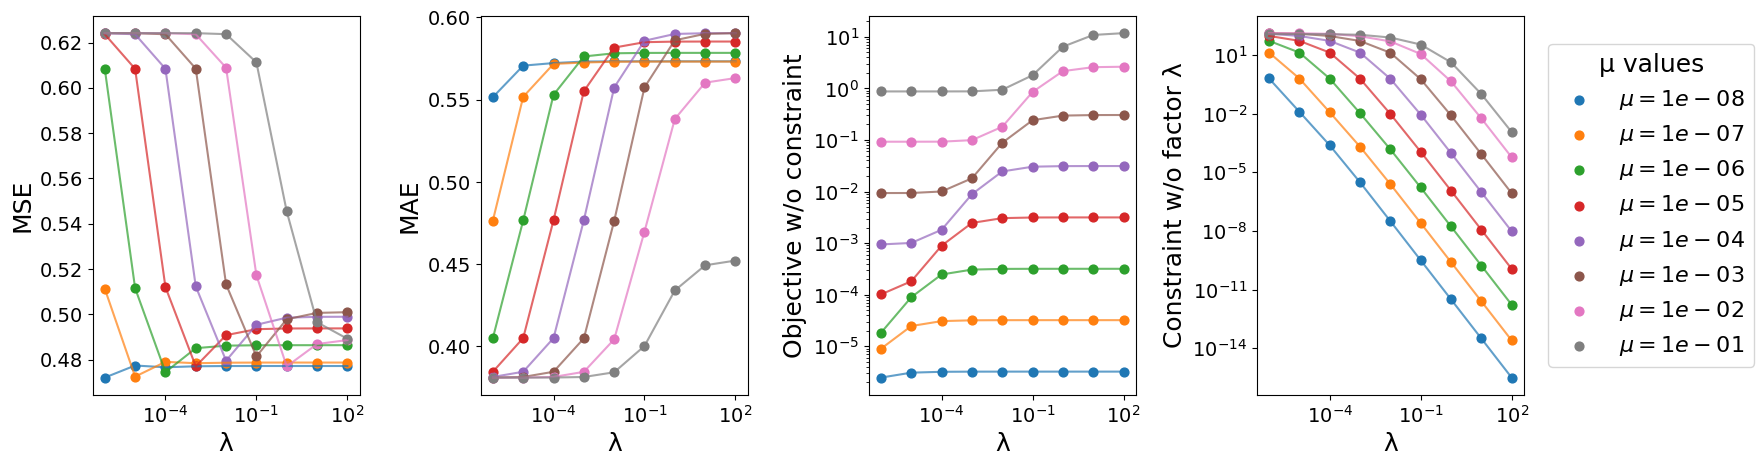

In [6]:
# Define functions
def J_1_parameters_without_constraint(x, lambd, mu):
    Dx_minus_d = D @ x - d
    return (
        0.5 * np.vdot(Dx_minus_d, Dx_minus_d).real
        + 0.5 * mu * np.vdot(x, x).real
    )

def constraint_parameters(x, lambd):
    Ex = E @ x
    return np.vdot(Ex, Ex).real

# Compute the closed-form solution
rhs = D.conj().T @ d
K_op_closed = np.empty((mus.shape[0], lambds.shape[0]), dtype=object)
x_1_closed_form = np.zeros((mus.shape[0], lambds.shape[0], rhs.shape[0]), dtype=np.complex128)
for i_mu, mu_val in enumerate(mus):
    for j_lambd, lambd_val in enumerate(lambds):
        K_op_closed[i_mu, j_lambd] = (
            D.conj().T @ D
            + lambd_val * (E_star @ E)
            + mu_val * sp.eye(I * L + P)
        )
        x_1_closed_form[i_mu, j_lambd] = sp.linalg.spsolve(K_op_closed[i_mu, j_lambd], rhs)

# Compute the metrics
m_pred = x_1_closed_form[:, :, -P:]
mse_values = mse(m, m_pred)
mae_values = mae(m, m_pred)
objective_without_constraint = np.array([
    [
        J_1_parameters_without_constraint(x_1_closed_form[i, j], lambds[j], mus[i])
        for j in range(len(lambds))
    ]
    for i in range(len(mus))
])
constraint = np.array([
    [
        constraint_parameters(x_1_closed_form[i, j], lambds[j])
        for j in range(len(lambds))
    ]
    for i in range(len(mus))
])

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

plt.rcParams.update({
        "font.size": 18,
        "axes.titlesize": 20,
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 16,
})    

for i_mu, mu_val in enumerate(mus):
    label = f"$\\mu={mu_val:.0e}$"
    axs[0].scatter(lambds, mse_values[i_mu], label=label, s=40)
    axs[0].plot(lambds, mse_values[i_mu], linestyle='-', alpha=0.7)
    axs[1].scatter(lambds, mae_values[i_mu], label=label, s=40)
    axs[1].plot(lambds, mae_values[i_mu], linestyle='-', alpha=0.7)
    axs[2].scatter(lambds, objective_without_constraint[i_mu], label=label, s=40)
    axs[2].plot(lambds, objective_without_constraint[i_mu], linestyle='-', alpha=0.7)
    axs[3].scatter(lambds, constraint[i_mu], label=label, s=40)
    axs[3].plot(lambds, constraint[i_mu], linestyle='-', alpha=0.7)

axs[2].set_yscale("log")
axs[3].set_yscale("log")
for ax in axs:
    ax.set_xlabel("λ")
    ax.set_xscale("log")
axs[3].legend(
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    title="μ values"
)

axs[0].set_ylabel("MSE")
axs[1].set_ylabel("MAE")
axs[2].set_ylabel("Objective w/o constraint")
axs[3].set_ylabel("Constraint w/o factor λ")

plt.tight_layout()
plt.show()

##### FISTA

In [7]:
max_iterations = 30000

2025-09-16 16:44:10 - iwp - INFO - Started μ=1e-08 for a maximum of 30000 iterations.
2025-09-16 16:48:03 - iwp - INFO - Stopped after 30000 iterations in 232.832 seconds with 486.93 KB memory used.
2025-09-16 16:48:04 - iwp - INFO - Started μ=1e-07 for a maximum of 30000 iterations.
2025-09-16 16:51:56 - iwp - INFO - Stopped after 30000 iterations in 232.324 seconds with 412.18 KB memory used.
2025-09-16 16:51:57 - iwp - INFO - Started μ=1e-06 for a maximum of 30000 iterations.
2025-09-16 16:55:47 - iwp - INFO - Stopped after 30000 iterations in 230.585 seconds with 424.62 KB memory used.
2025-09-16 16:55:48 - iwp - INFO - Started μ=1e-05 for a maximum of 30000 iterations.
2025-09-16 16:59:39 - iwp - INFO - Stopped after 30000 iterations in 231.553 seconds with 419.00 KB memory used.
2025-09-16 16:59:40 - iwp - INFO - Started μ=1e-04 for a maximum of 30000 iterations.
2025-09-16 17:03:31 - iwp - INFO - Stopped after 30000 iterations in 231.368 seconds with 416.64 KB memory used.
2025-

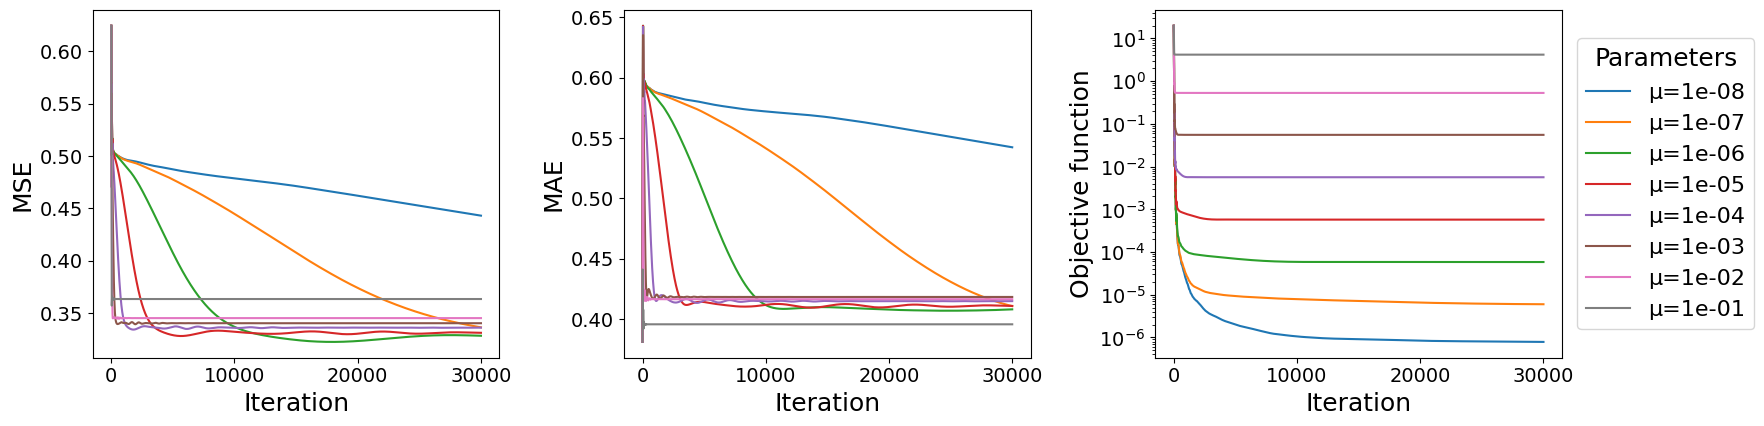

In [8]:
algo_list = []
x_list = []
for mu_val in mus:
    J_2 = get_J_2(d, mu_val)
    grad_J_2 = get_grad_J_2(d, mu_val)
    prox_J_2 = get_prox_J_2()
    K_J_2 = get_K_J_2(mu_val)

    algo = FISTA(
        exp_name=args.exp_name,
        algo_plot_name=f"μ={mu_val:.0e}",
        f=J_2,
        grad=grad_J_2,
        prox=prox_J_2,
        K=K_J_2,
        logger=logger,
    )
    x = algo.run(x0=x_0, max_iterations=max_iterations)
    algo.plot_algorithm_convergence(m, None, show=False, save=False)
    algo_list.append(algo)
    x_list.append(x)

plot_all_algorithms_convergence(
    algorithms=algo_list,
    visuals_path=None,
    show=True,
    save=False,
    show_time_memory=False,
)

##### C-NAGD

In [9]:
max_iterations = 3000

2025-09-16 17:15:11 - iwp - INFO - Started μ=1e-08 for a maximum of 3000 iterations.
2025-09-16 17:15:31 - iwp - INFO - Converged after 2341 iterations in 19.655 seconds with 151.52 KB memory used.
2025-09-16 17:15:31 - iwp - INFO - Started μ=1e-07 for a maximum of 3000 iterations.
2025-09-16 17:15:51 - iwp - INFO - Converged after 2335 iterations in 19.449 seconds with 89.83 KB memory used.
2025-09-16 17:15:51 - iwp - INFO - Started μ=1e-06 for a maximum of 3000 iterations.
2025-09-16 17:16:09 - iwp - INFO - Converged after 2150 iterations in 17.999 seconds with 70.80 KB memory used.
2025-09-16 17:16:09 - iwp - INFO - Started μ=1e-05 for a maximum of 3000 iterations.
2025-09-16 17:16:26 - iwp - INFO - Converged after 1938 iterations in 16.192 seconds with 85.68 KB memory used.
2025-09-16 17:16:26 - iwp - INFO - Started μ=1e-04 for a maximum of 3000 iterations.
2025-09-16 17:16:38 - iwp - INFO - Converged after 1441 iterations in 12.058 seconds with 79.41 KB memory used.
2025-09-16 17:

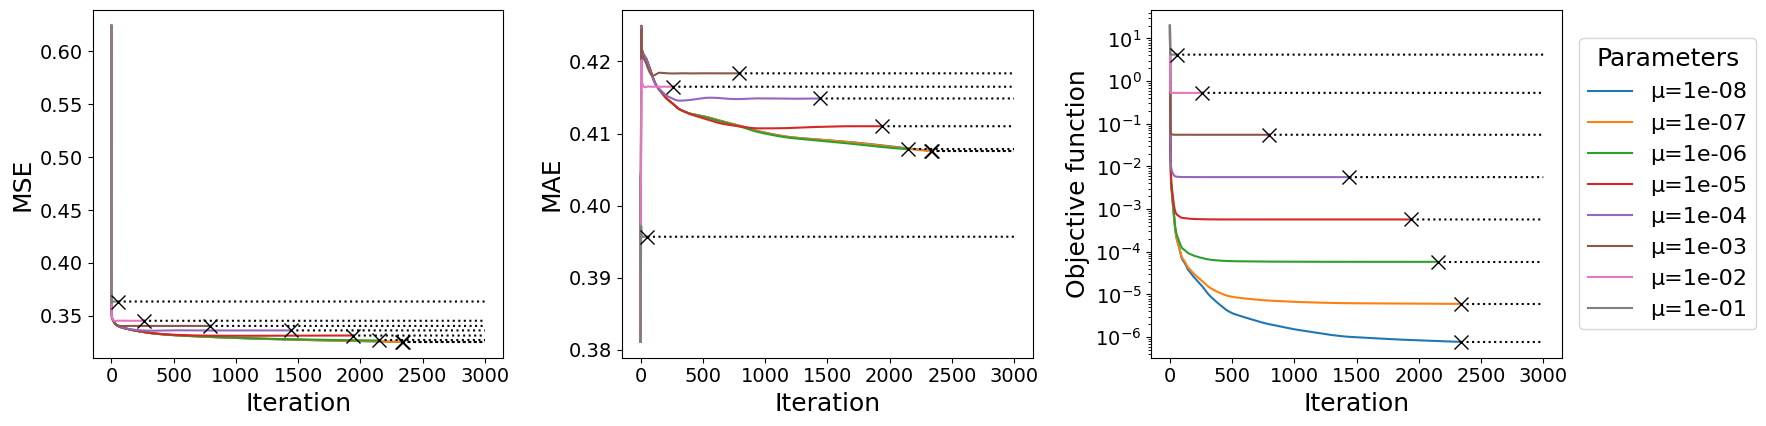

In [10]:
algo_list = []
x_list = []
for mu_val in mus:
    J_3 = get_J_3(d_list, mu_val)
    dJ_3 = get_dJ_3(d_list, mu_val)
    K_J_3 = get_K_J_3(mu_val)

    algo = NesterovAcceleratedGradientDescent(
        exp_name=args.exp_name,
        algo_plot_name=f"μ={mu_val:.0e}",
        f=J_3,
        df=dJ_3,
        K=K_J_3,
        logger=logger,
    )
    x = algo.run(x0=x_0[-P:], max_iterations=max_iterations)
    algo.plot_algorithm_convergence(m, None, show=False, save=False)
    algo_list.append(algo)
    x_list.append(x)

plot_all_algorithms_convergence(
    algorithms=algo_list,
    visuals_path=None,
    show=True,
    save=False,
    show_time_memory=False,
)